In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(123)
if device =='cuda':
    torch.cuda.manual_seed_all(123)

print(device)

cuda


In [4]:
imsize = 512 if torch.cuda.is_available() else 128

transform = transforms.Compose([
                 transforms.Resize(imsize),
                 transforms.CenterCrop(imsize),
                 transforms.ToTensor()])

def img_loader(image_name):
  image = Image.open(image_name)
  image = transform(image).unsqueeze(0)
  return image.to(device, torch.float)

style_img = img_loader("/content/gdrive/MyDrive/파이토치로 시작하는 딥러닝 기초/화풍 따라하기/img/kiss.jpg")
content_img = img_loader("/content/gdrive/MyDrive/파이토치로 시작하는 딥러닝 기초/화풍 따라하기/img/my pic.jpg")


print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


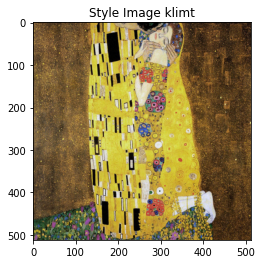

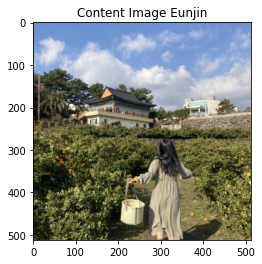

In [5]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title = None):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  fig = plt.gcf()
  plt.imshow(image)
  fig.savefig(str(title)+'.png')
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

plt.figure()
imshow(style_img, title = "Style Image klimt")

plt.figure()
imshow(content_img, title = "Content Image Eunjin")

## Loss Funcion

## Content Loss

In [6]:
class ContentLoss(nn.Module):
  
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input


## Style Loss

In [7]:
def gram_matrix(input):
  a, b, c, d = input.size()
  # a=batch size(=1)
  # b = number of feature maps
  # (c,d) = dimensions of a f. map (N=c*d)

  features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

  G = torch.mm(features, features.t())

  # 'normalize' the values of the gram matrix by dividing by the number of element in each feature maps.
  return G.div(a * b * c * d)

In [8]:
class StyleLoss(nn.Module):
  
  def __init__(self, target_features):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_features)

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

# Importing the Model

- PyTorch’s implementation of VGG : features (containing convolution and pooling layers), and classifier (containing fully connected layers). 
- Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().

In [9]:
cnn = models.vgg19(pretrained = True).features.to(device).eval()

In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can directly work with image Tensor of shape [B x C x H x W].
        # B = batch size, C = number of channels, H = height, W = width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [11]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, 
                               content_layers = content_layers_default,
                               style_layers = style_layers_default):
  normalization = Normalization(normalization_mean, normalization_std).to(device)

  content_losses = []
  style_losses = []

  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)

      layer = nn.ReLU(inplace=False)

    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
  
  # now we trim off the layers after the last content and style losses
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  
  model = model[:(i + 1)]

  return model, style_losses, content_losses


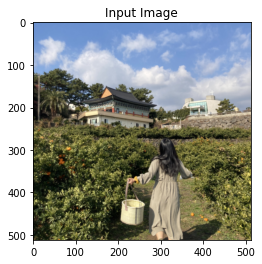

In [12]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title="Input Image")

## Gradient Descent

In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


run [50]:
Style Loss : 92.115128 Content Loss: 20.433830

run [100]:
Style Loss : 21.546129 Content Loss: 19.970186

run [150]:
Style Loss : 9.229889 Content Loss: 16.916401

run [200]:
Style Loss : 5.689152 Content Loss: 14.301598

run [250]:
Style Loss : 4.062983 Content Loss: 12.780199

run [300]:
Style Loss : 3.129688 Content Loss: 11.808138



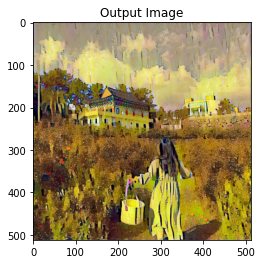

In [15]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()